In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.utils import save_image
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HR_SIZE = 96     # Taille des images Haute Résolution
LR_SIZE = 24     # Taille des images Basse Résolution (Scale x4)
BATCH_SIZE = 16
EPOCHS_PRETRAIN = 5
EPOCHS_GAN = 10
# 1. Création des dossiers
os.makedirs("data/hr", exist_ok=True)
os.makedirs("data/lr", exist_ok=True)
os.makedirs("results", exist_ok=True)
# 2. Téléchargement d'une image HD (Version Blindée)
# On utilise un User-Agent pour éviter le blocage 403 Forbidden
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
# URL principale (Perroquet HD)
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Ara_ararauna_Luc_Viatour.jpg/1200px-Ara_ararauna_Luc_Viatour.jpg"
# URL de secours (Zèbre, hébergé sur GitHub, très stable)
backup_url = "https://raw.githubusercontent.com/k4d3/ML_Data/master/Image_Processing/zebra.jpg"
try:
    print(f"Tentative de téléchargement depuis : {url}")
    response = requests.get(url, headers=headers, timeout=10)
    response.raise_for_status() # Vérifie si on a une erreur 404 ou 403
    img = Image.open(BytesIO(response.content)).convert("RGB")
    print("✅ Image principale téléchargée avec succès.")
except Exception as e:
    print(f"⚠️ Échec du lien principal ({e}). Tentative avec le lien de secours...")
    response = requests.get(backup_url, headers=headers)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    print("✅ Image de secours téléchargée.")
# 3. Création du dataset (Découpage en patches)
print("🛠️ Préparation du dataset synthétique...")
width, height = img.size
count = 0
# On limite à 200 patches pour que l'entraînement soit rapide en démo
limit_patches = 200
for i in range(0, width - HR_SIZE, HR_SIZE):
    for j in range(0, height - HR_SIZE, HR_SIZE):
        if count >= limit_patches: break

        box = (i, j, i + HR_SIZE, j + HR_SIZE)
        hr_patch = img.crop(box)
        lr_patch = hr_patch.resize((LR_SIZE, LR_SIZE), Image.BICUBIC)

        hr_patch.save(f"data/hr/{count}.png")
        lr_patch.save(f"data/lr/{count}.png")
        count += 1
    if count >= limit_patches: break
print(f"✅ Dataset prêt : {count} paires d'images créées dans data/hr et data/lr.")
# 4. Classe Dataset PyTorch
class SRDataset(Dataset):
    def __init__(self):
        self.hr_files = sorted(os.listdir("data/hr"))
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.hr_files)

    def __getitem__(self, idx):
        # On ajoute un try/except au cas où un fichier serait corrompu (prudence)
        try:
            hr = Image.open(f"data/hr/{self.hr_files[idx]}").convert("RGB")
            lr = Image.open(f"data/lr/{self.hr_files[idx]}").convert("RGB")
            return self.transform(lr), self.transform(hr)
        except:
            # Si erreur, on retourne des tenseurs vides (ne devrait pas arriver ici)
            return torch.zeros(3, LR_SIZE, LR_SIZE), torch.zeros(3, HR_SIZE, HR_SIZE)
dataloader = DataLoader(SRDataset(), batch_size=BATCH_SIZE, shuffle=True)
print("🚀 Tout est prêt pour l'étape 2 (Architecture) !")

Tentative de téléchargement depuis : https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Ara_ararauna_Luc_Viatour.jpg/1200px-Ara_ararauna_Luc_Viatour.jpg
✅ Image principale téléchargée avec succès.
🛠️ Préparation du dataset synthétique...
✅ Dataset prêt : 108 paires d'images créées dans data/hr et data/lr.
🚀 Tout est prêt pour l'étape 2 (Architecture) !


In [3]:
# --- BLOCS DE BASE ---
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
        return x + residual

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * scale_factor ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

# --- GENERATEUR ---
class Generator(nn.Module):
    def __init__(self, scale_factor=4, num_residuals=16):
        super(Generator, self).__init__()
        self.input_conv = nn.Sequential(nn.Conv2d(3, 64, 9, padding=4), nn.PReLU())
        self.residuals = nn.Sequential(*[ResidualBlock(64) for _ in range(num_residuals)])
        self.mid_conv = nn.Sequential(nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64))
        self.upsamples = nn.Sequential(
            UpsampleBlock(64, 2),
            UpsampleBlock(64, 2)
        ) # x2 * x2 = x4
        self.final_conv = nn.Conv2d(64, 3, 9, padding=4)

    def forward(self, x):
        initial = self.input_conv(x)
        x = self.residuals(initial)
        x = self.mid_conv(x) + initial
        x = self.upsamples(x)
        return torch.sigmoid(self.final_conv(x)) # Sortie entre 0 et 1

# --- DISCRIMINATEUR ---
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def discriminator_block(in_filters, out_filters, strides=1, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, stride=strides, padding=1), nn.LeakyReLU(0.2, inplace=True)]
            if bn: block.append(nn.BatchNorm2d(out_filters))
            return block

        self.model = nn.Sequential(
            *discriminator_block(3, 64, strides=1, bn=False),
            *discriminator_block(64, 64, strides=2),
            *discriminator_block(64, 128, strides=1),
            *discriminator_block(128, 128, strides=2),
            *discriminator_block(128, 256, strides=1),
            *discriminator_block(256, 256, strides=2),
            *discriminator_block(256, 512, strides=1),
            *discriminator_block(512, 512, strides=2),
            nn.Flatten(),
            nn.Linear(512 * 6 * 6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

print("✅ Modèles Générateur et Discriminateur définis.")

✅ Modèles Générateur et Discriminateur définis.


In [4]:
class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features[:36].eval().to(DEVICE)
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.criterion = nn.MSELoss()

    def forward(self, input, target):
        return self.criterion(self.vgg(input), self.vgg(target))

print("✅ VGG Loss prête (Téléchargement des poids ImageNet effectué).")

✅ VGG Loss prête (Téléchargement des poids ImageNet effectué).


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:06<00:00, 82.2MB/s]



🚀 Phase 1 : Entraînement Standard (SRResNet) - 5 époques
[Phase 1] Epoch 1/5 - Loss: 0.0222
[Phase 1] Epoch 2/5 - Loss: 0.0146
[Phase 1] Epoch 3/5 - Loss: 0.0152
[Phase 1] Epoch 4/5 - Loss: 0.0045
[Phase 1] Epoch 5/5 - Loss: 0.0053

🚀 Phase 2 : Entraînement GAN (SRGAN) - 10 époques
[Phase 2] Epoch 1/10 - D Loss: 0.0431 | G Loss: 0.1770
[Phase 2] Epoch 2/10 - D Loss: 0.0043 | G Loss: 0.4008
[Phase 2] Epoch 3/10 - D Loss: 0.0070 | G Loss: 0.2151
[Phase 2] Epoch 4/10 - D Loss: 0.0043 | G Loss: 0.1595
[Phase 2] Epoch 5/10 - D Loss: 0.0082 | G Loss: 0.1841
[Phase 2] Epoch 6/10 - D Loss: 0.1320 | G Loss: 0.2049
[Phase 2] Epoch 7/10 - D Loss: 0.0021 | G Loss: 0.2307
[Phase 2] Epoch 8/10 - D Loss: 0.2380 | G Loss: 0.1800
[Phase 2] Epoch 9/10 - D Loss: 0.0176 | G Loss: 0.1656
[Phase 2] Epoch 10/10 - D Loss: 0.1695 | G Loss: 0.1280
✅ Entraînement terminé !


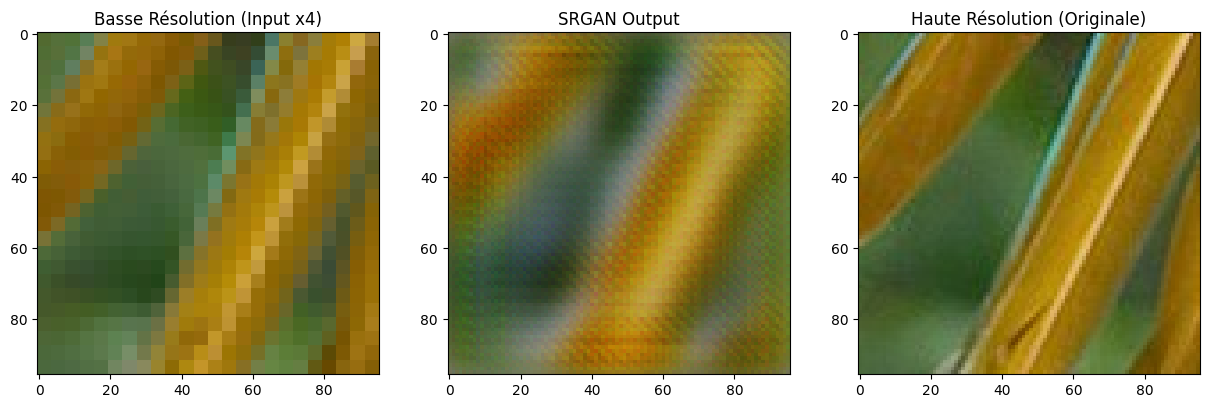

In [5]:
# Initialisation
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)
vgg_loss = VGGLoss()
mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.9, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.9, 0.999))
# --- PHASE 1 : Warmup (Entraînement PSNR seulement) ---
print(f"\n🚀 Phase 1 : Entraînement Standard (SRResNet) - {EPOCHS_PRETRAIN} époques")
for epoch in range(EPOCHS_PRETRAIN):
    for i, (imgs_lr, imgs_hr) in enumerate(dataloader):
        imgs_lr, imgs_hr = imgs_lr.to(DEVICE), imgs_hr.to(DEVICE)

        optimizer_G.zero_grad()
        gen_hr = generator(imgs_lr)
        loss = mse_loss(gen_hr, imgs_hr)
        loss.backward()
        optimizer_G.step()

    print(f"[Phase 1] Epoch {epoch+1}/{EPOCHS_PRETRAIN} - Loss: {loss.item():.4f}")
# --- PHASE 2 : SRGAN (Adversarial Training) ---
print(f"\n🚀 Phase 2 : Entraînement GAN (SRGAN) - {EPOCHS_GAN} époques")
for epoch in range(EPOCHS_GAN):
    for i, (imgs_lr, imgs_hr) in enumerate(dataloader):
        imgs_lr, imgs_hr = imgs_lr.to(DEVICE), imgs_hr.to(DEVICE)

        # Labels pour le discriminateur (Vrai = 1, Faux = 0)
        valid = torch.ones(imgs_lr.size(0), 1, requires_grad=False).to(DEVICE)
        fake = torch.zeros(imgs_lr.size(0), 1, requires_grad=False).to(DEVICE)
        # ------------------
        #  Train Generator
        # ------------------
        optimizer_G.zero_grad()
        gen_hr = generator(imgs_lr)

        # Loss 1: Perceptual Loss (VGG)
        loss_content = vgg_loss(gen_hr, imgs_hr)

        # Loss 2: Adversarial Loss (Tromper le discriminateur)
        loss_adversarial = bce_loss(discriminator(gen_hr), valid)

        # Loss 3: Pixel Loss (Optionnel mais aide à la stabilité)
        loss_pixel = mse_loss(gen_hr, imgs_hr)

        # Total Loss (0.006 et 0.001 sont les standards du papier SRGAN)
        loss_G = loss_content + 0.001 * loss_adversarial + 10 * loss_pixel

        loss_G.backward()
        optimizer_G.step()
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        loss_real = bce_loss(discriminator(imgs_hr), valid)
        loss_fake = bce_loss(discriminator(gen_hr.detach()), fake)
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()
    print(f"[Phase 2] Epoch {epoch+1}/{EPOCHS_GAN} - D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")
print("✅ Entraînement terminé !")
# --- VISUALISATION DU RESULTAT ---
def show_result():
    generator.eval()
    with torch.no_grad():
        # Prendre une image au hasard
        idx = np.random.randint(0, len(dataloader.dataset))
        lr, hr = dataloader.dataset[idx]
        lr = lr.unsqueeze(0).to(DEVICE)

        # Générer
        sr = generator(lr).cpu().squeeze(0)
        lr = lr.cpu().squeeze(0)

        # Afficher
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Basse Résolution (Zoomée pour comparer)
        lr_img = transforms.ToPILImage()(lr)
        lr_img = lr_img.resize((HR_SIZE, HR_SIZE), Image.NEAREST)
        axes[0].imshow(lr_img)
        axes[0].set_title("Basse Résolution (Input x4)")

        # SRGAN
        axes[1].imshow(transforms.ToPILImage()(sr))
        axes[1].set_title("SRGAN Output")

        # Originale
        axes[2].imshow(transforms.ToPILImage()(hr))
        axes[2].set_title("Haute Résolution (Originale)")
        plt.show()
show_result()

📤 Veuillez uploader une image de test (JPG ou PNG)...


Saving CleanShot 2026-02-10 at 15.25.35@2x.png to CleanShot 2026-02-10 at 15.25.35@2x.png
Processing CleanShot 2026-02-10 at 15.25.35@2x.png...


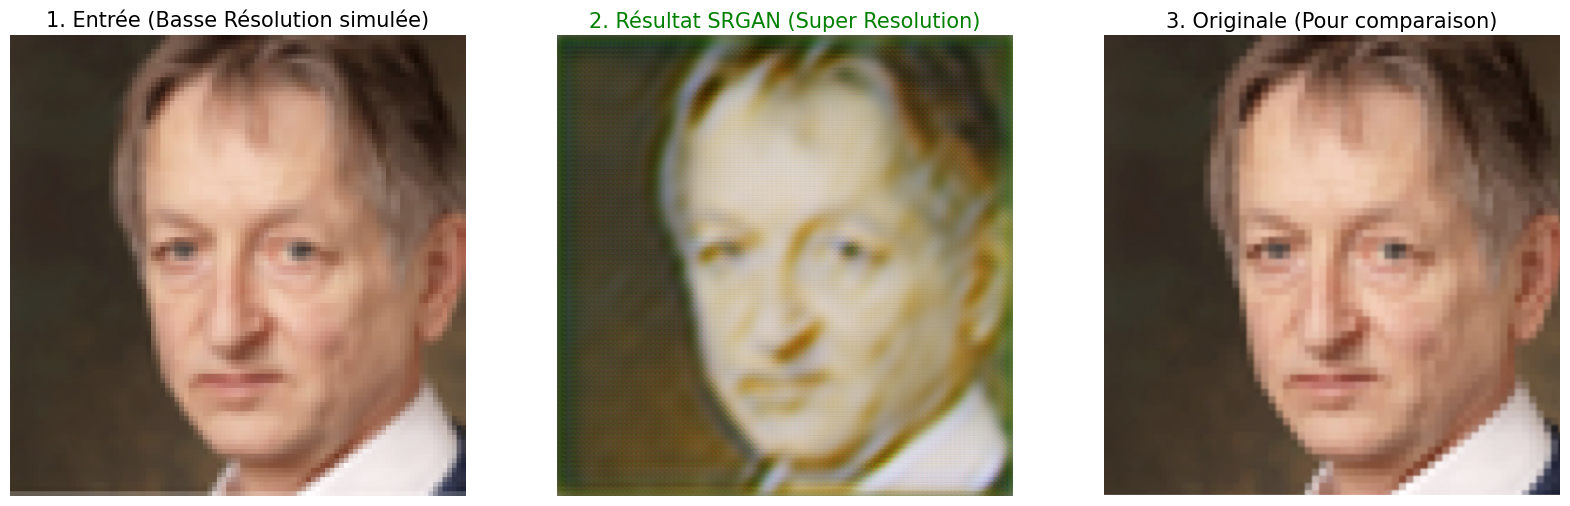

✅ Image sauvegardée sous : resultat_srgan_CleanShot 2026-02-10 at 15.25.35@2x.png


In [6]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
# 1. Fonction d'upload et de test
def test_custom_image():
    print("📤 Veuillez uploader une image de test (JPG ou PNG)...")
    uploaded = files.upload()
    for fn in uploaded.keys():
        print(f'Processing {fn}...')

        # 2. Chargement et Préparation
        img_path = fn
        original = Image.open(img_path).convert("RGB")

        # On redimensionne l'original pour qu'il soit divisible par 4 (plus propre pour le test)
        w, h = original.size
        w, h = (w // 4) * 4, (h // 4) * 4
        original = original.resize((w, h), Image.BICUBIC)

        # Création de l'entrée "Basse Résolution" (Ce que le modèle va voir)
        # On réduit l'image par 4 -> Elle devient floue/pixelisée
        lr_image = original.resize((w // 4, h // 4), Image.BICUBIC)

        # 3. Inférence (Passage dans le modèle)
        generator.eval() # Mode évaluation
        with torch.no_grad():
            # Transformation en Tenseur + Envoi sur GPU
            img_tensor = transforms.ToTensor()(lr_image).unsqueeze(0).to(DEVICE)

            # Génération
            sr_tensor = generator(img_tensor)

            # Récupération du résultat (GPU -> CPU -> Image)
            sr_image = transforms.ToPILImage()(sr_tensor.squeeze(0).cpu())
        # 4. Affichage des résultats
        fig, axes = plt.subplots(1, 3, figsize=(20, 10))

        # Image Basse Résolution (Zoomée pour qu'on voie les pixels)
        # On utilise NEAREST pour bien montrer les gros pixels moches
        lr_display = lr_image.resize((w, h), Image.NEAREST)
        axes[0].imshow(lr_display)
        axes[0].set_title("1. Entrée (Basse Résolution simulée)", fontsize=15)
        axes[0].axis('off')
        # Résultat SRGAN
        axes[1].imshow(sr_image)
        axes[1].set_title("2. Résultat SRGAN (Super Resolution)", fontsize=15, color='green')
        axes[1].axis('off')
        # Vérité Terrain (L'originale)
        axes[2].imshow(original)
        axes[2].set_title("3. Originale (Pour comparaison)", fontsize=15)
        axes[2].axis('off')

        plt.show()

        # Sauvegarde du résultat
        sr_image.save(f"resultat_srgan_{fn}")
        print(f"✅ Image sauvegardée sous : resultat_srgan_{fn}")
# Lancer la fonction
test_custom_image()